In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Unsupervised_learning/A4')

In [4]:
train = pd.read_csv('assignment-4-option-1-training.csv')
test = pd.read_csv('assignment-4-option-1-test.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133731 entries, 0 to 133730
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      133731 non-null  object 
 1   Prod    133731 non-null  object 
 2   Quant   129252 non-null  float64
 3   Val     133215 non-null  float64
 4   Insp    133731 non-null  object 
dtypes: float64(2), object(3)
memory usage: 5.1+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15732 entries, 0 to 15731
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      15732 non-null  object 
 1   Prod    15732 non-null  object 
 2   Quant   15592 non-null  float64
 3   Val     15683 non-null  float64
 4   Insp    15732 non-null  object 
dtypes: float64(2), object(3)
memory usage: 614.7+ KB


In [5]:
train.drop(columns=['ID','Insp'], inplace=True)

In [6]:
# drop NA
train.dropna(inplace=True)
test.dropna(inplace=True)

In [ ]:
test['Insp'].value_counts()

,count
Insp,
ok,14347
fraud,1199


In [7]:
X_test = test.drop(columns=['ID','Insp'], inplace=False)
y_test = test['Insp'].map({'fraud':1,'ok':0})

In [ ]:
# Check if all product categories in X_test are in train
test_prods = X_test['Prod'].unique()
train_prods = train['Prod'].unique()

all_test_prods_in_train = np.all(np.isin(test_prods, train_prods))

if all_test_prods_in_train:
    print("All product categories in the test set are present in the training set.")
else:
    print("Some product categories in the test set are NOT present in the training set.")
    missing_prods = test_prods[~np.isin(test_prods, train_prods)]
    print(f"Missing product categories: {missing_prods}")

All product categories in the test set are present in the training set.


<Axes: xlabel='Prod', ylabel='count'>

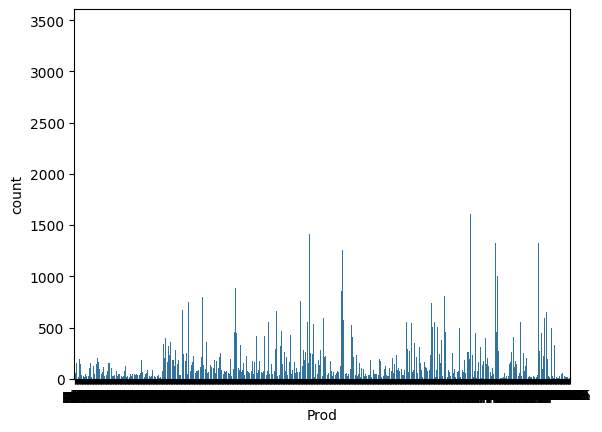

In [ ]:
# plot product column
sns.countplot(x='Prod', data=train)

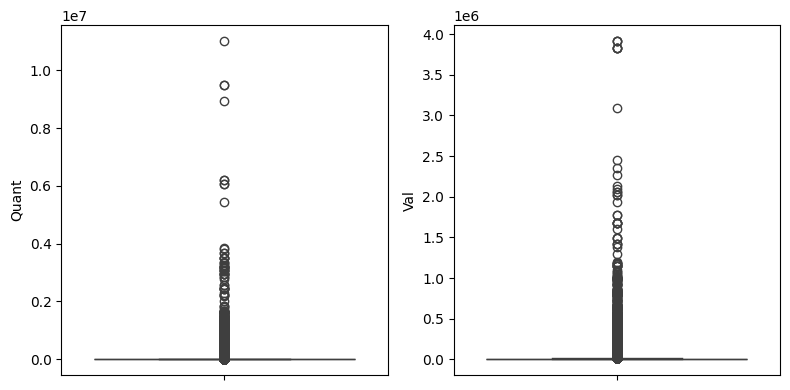

In [8]:
numeric_col = train.columns[train.dtypes != 'object']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
for i,col in enumerate(numeric_col):
  sns.boxplot(y=col, data=train, ax=axes[i])
plt.tight_layout()
plt.show()

In [ ]:
correlation_by_prod = train.groupby('Prod')[['Quant', 'Val']].corr().unstack().iloc[:, 1]

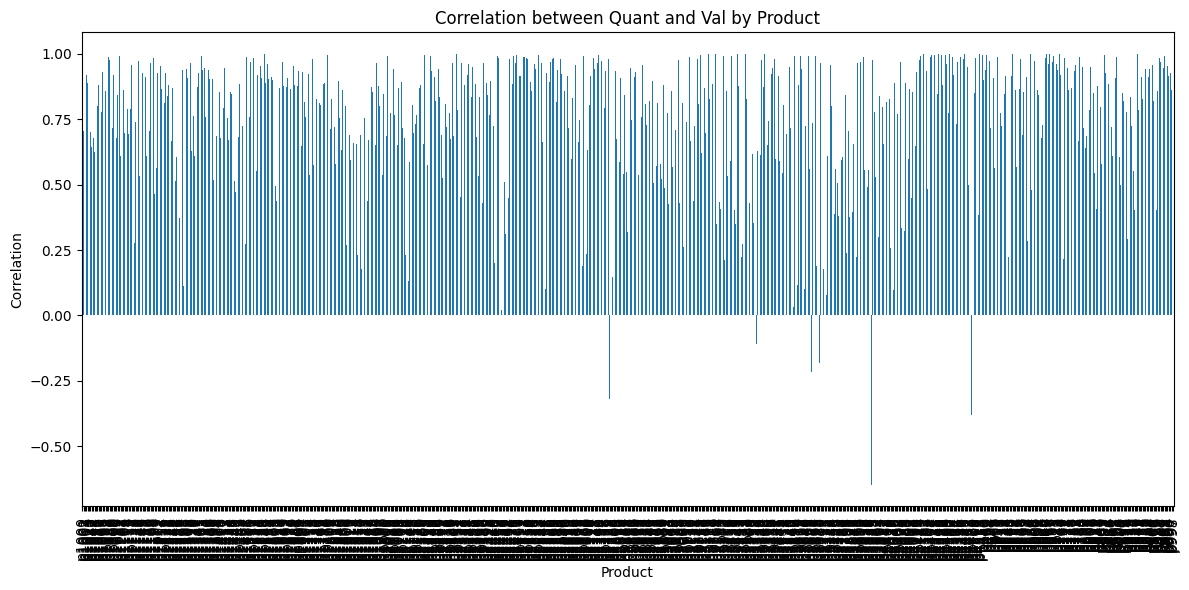

In [ ]:
plt.figure(figsize=(12, 6))
correlation_by_prod.plot(kind='bar')
plt.title('Correlation between Quant and Val by Product')
plt.xlabel('Product')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<Axes: xlabel='Quant', ylabel='Val'>

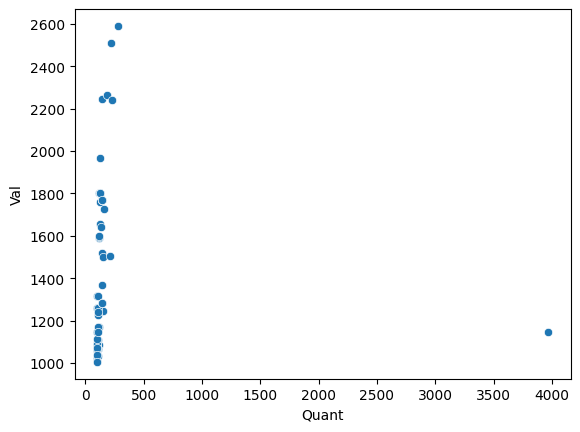

In [ ]:
# plot quant and val for product p2189
sns.scatterplot(x='Quant', y='Val', data=train[train['Prod'] == 'p2189'])

<Axes: xlabel='Quant', ylabel='Val'>

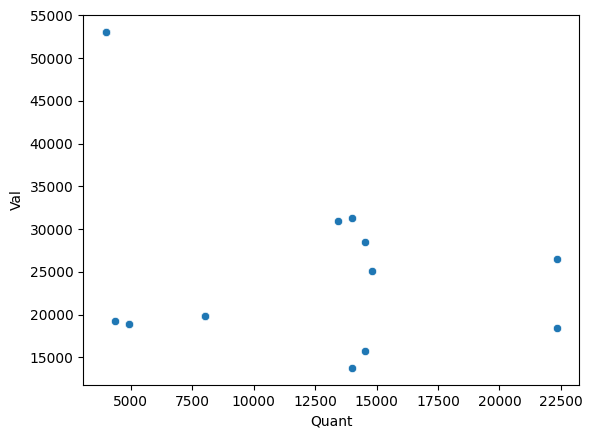

In [ ]:
sns.scatterplot(x='Quant', y='Val', data=train[train['Prod'] == 'p4484'])

In [9]:
train['Price'] = train['Val']/train['Quant']
X_test['Price'] = X_test['Val']/X_test['Quant']

<Axes: ylabel='Price'>

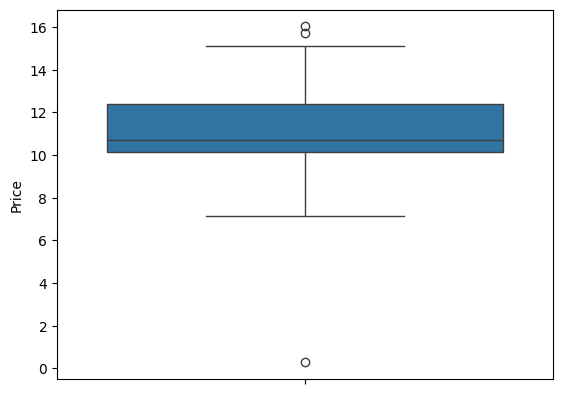

In [ ]:
sns.boxplot(y='Price', data=train[train['Prod'] == 'p2189'])

<Axes: ylabel='Price'>

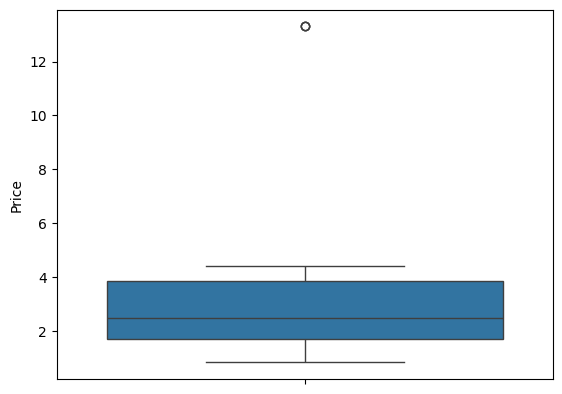

In [ ]:
sns.boxplot(y='Price', data=train[train['Prod'] == 'p4484'])

In [ ]:
def predict_outliers_iqr(train_df, test_df):
    outliers = pd.DataFrame()
    for prod in train_df['Prod'].unique():
        train_prod_df = train_df[train_df['Prod'] == prod]
        test_prod_df = test_df[test_df['Prod'] == prod]

        if not train_prod_df.empty:
            Q1 = train_prod_df['Price'].quantile(0.25)
            Q3 = train_prod_df['Price'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            prod_outliers = test_prod_df[(test_prod_df['Price'] < lower_bound) | (test_prod_df['Price'] > upper_bound)]
            outliers = pd.concat([outliers, prod_outliers])
    return outliers

In [ ]:
price_outliers_test = predict_outliers_iqr(train, X_test)

In [ ]:
price_outliers_test.shape

(3907, 4)

In [ ]:
price_outlier_predictions = pd.Series(0, index=X_test.index)
price_outlier_predictions[price_outliers_test.index] = 1

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score
auc = roc_auc_score(y_test, price_outlier_predictions)
precision = average_precision_score(y_test, price_outlier_predictions)
recall = recall_score(y_test, price_outlier_predictions)
f1 = f1_score(y_test, price_outlier_predictions)
print(f'AUC: {auc}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

AUC: 0.6801443990435329, Precision: 0.13669872276321474, Recall: 0.5838198498748958, F1-Score: 0.27418723070896983


In [10]:
numeric_col_list = numeric_col.tolist()
numeric_col_list.append('Price')
train_log = train.copy()
X_test_copy = X_test.copy()

for col in numeric_col_list:
  train_log[col] = np.log1p(train_log[col])
  X_test_copy[col] = np.log1p(X_test_copy[col])

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
X_test_scaled = X_test_copy.copy()
train_log_scaled = train_log.copy()

for prod in train_log_scaled['Prod'].unique():
    train_prod_df = train_log_scaled[train_log_scaled['Prod'] == prod].copy()
    test_prod_df = X_test_scaled[X_test_scaled['Prod'] == prod].copy()

    if not train_prod_df.empty:
        scaler = MinMaxScaler().fit(train_prod_df[numeric_col_list])
        train_log_scaled.loc[train_prod_df.index, numeric_col_list] = scaler.transform(train_prod_df[numeric_col_list])
        X_test_scaled.loc[test_prod_df.index, numeric_col_list] = scaler.transform(test_prod_df[numeric_col_list])

### DBSCAN

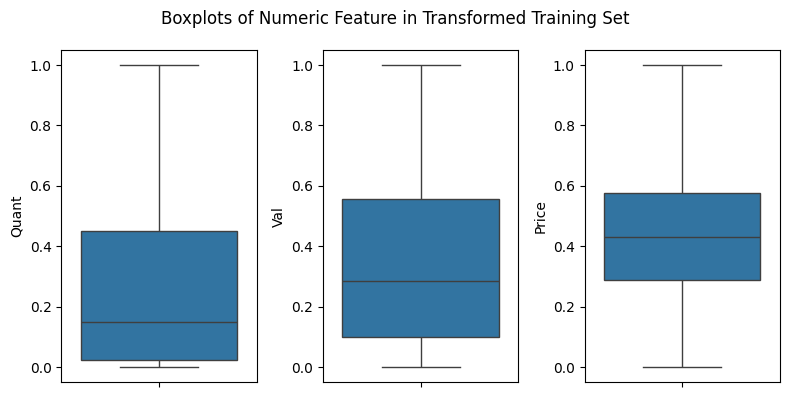

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
for i,col in enumerate(numeric_col_list):
  sns.boxplot(y=col, data=train_log_scaled, ax=axes[i])
fig.suptitle('Boxplots of Numeric Feature in Transformed Training Set')
plt.tight_layout()
plt.show()

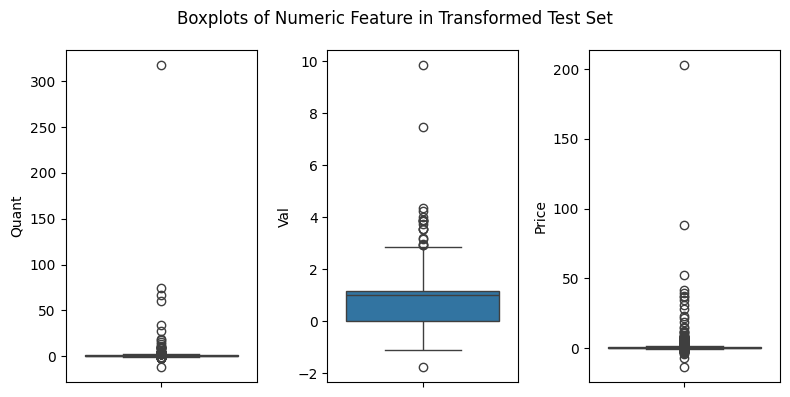

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
for i,col in enumerate(numeric_col_list):
  sns.boxplot(y=col, data=X_test_scaled, ax=axes[i])
fig.suptitle('Boxplots of Numeric Feature in Transformed Test Set')
plt.tight_layout()
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train_log_scaled['Prod'] = labelencoder.fit_transform(train_log_scaled['Prod'])
X_test_scaled['Prod'] = labelencoder.transform(X_test_scaled['Prod'])

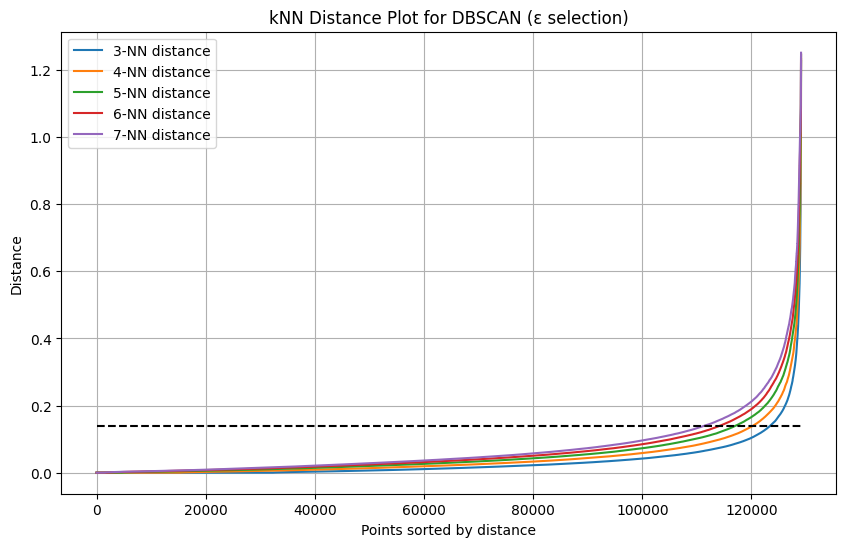

In [ ]:
from sklearn.neighbors import NearestNeighbors

plt.figure(figsize=(10, 6))
for min_samples in range(3,8):
  nbrs = NearestNeighbors(n_neighbors=min_samples).fit(train_log_scaled)
  distances, _ = nbrs.kneighbors(train_log_scaled)
  distances = np.sort(distances[:, min_samples-1])

  plt.plot(distances, label=f'{min_samples}-NN distance')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance')
plt.title('kNN Distance Plot for DBSCAN (ε selection)')
plt.hlines(y=0.14, xmin=0, xmax=len(train_log_scaled), linestyles='dashed', colors='black', label='Distance = 0.14')
plt.legend()
plt.grid(True)

In [15]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.14, min_samples=3, algorithm='auto', n_jobs=-1).fit(train_log_scaled)

In [ ]:
len(np.unique(dbscan.labels_))

2443

In [ ]:
sum(dbscan.labels_==-1)

np.int64(4550)

In [ ]:
dbscan.core_sample_indices_.shape

(123433,)

In [16]:
border_samples = train_log_scaled[(dbscan.labels_ != -1) & (~np.isin(np.arange(len(train_log_scaled)), dbscan.core_sample_indices_)) ]
display(border_samples.shape)

(1108, 4)

In [18]:
from sklearn.metrics import euclidean_distances

def dbscan_predict(dbscan_model, X_test, X_train):
  y_new = np.zeros(shape=len(X_test), dtype=float)
  core_samples_indices = dbscan_model.core_sample_indices_
  core_samples = X_train[core_samples_indices]
  eps = dbscan_model.eps

  for j, x_new in enumerate(X_test):
    if core_samples.size == 0:
      probability = 1.0
    else:
      distances = euclidean_distances(x_new.reshape(1, -1), core_samples)[0]
      min_dist = np.min(distances)

      if min_dist <= eps:
        probability = 0.0
      else:
        max_distance = 1.2
        probability = (min_dist - eps) / (max_distance - eps)
        probability = max(0.0, min(1.0, probability))

    y_new[j] = probability

  return y_new

In [19]:
dbscan_predicted_scores = dbscan_predict(dbscan, X_test_scaled.to_numpy(), train_log_scaled.to_numpy())

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score

def evaluate_model_at_cutoffs(y_true, y_scores, cutoffs):

    results = []
    auc = roc_auc_score(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    for cutoff in cutoffs:
      y_pred = np.where(y_scores > cutoff, 1, 0)
      precision = precision_score(y_true, y_pred, zero_division=0)
      recall = recall_score(y_true, y_pred, zero_division=0)
      f1 = f1_score(y_true, y_pred, zero_division=0)
      results.append({
        'cutoff': cutoff,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'average precision': avg_precision,
        'roc_auc': auc
      })

    return pd.DataFrame(results)

In [ ]:
y_pred = np.where(dbscan_predicted_scores > 0.0, 1, 0)
cm = confusion_matrix(y_test, y_pred)
display(cm)

array([[7901, 6446],
       [ 105, 1094]])

In [ ]:
cutoffs = np.arange(0.0, 0.95, 0.05).round(2)
results = evaluate_model_at_cutoffs(y_test, dbscan_predicted_scores, cutoffs)
results

,cutoff,precision,recall,f1_score,average precision,roc_auc
0,0.00,0.145093,0.912427,0.250372,0.363712,0.847932
1,0.05,0.163611,0.885738,0.276203,0.363712,0.847932
2,0.10,0.182434,0.854045,0.300646,0.363712,0.847932
3,0.15,0.201878,0.824854,0.324369,0.363712,0.847932
4,0.20,0.221500,0.795663,0.346531,0.363712,0.847932
5,0.25,0.239594,0.768140,0.365259,0.363712,0.847932
6,0.30,0.261841,0.733111,0.385865,0.363712,0.847932
7,0.35,0.276174,0.686405,0.393874,0.363712,0.847932
8,0.40,0.300454,0.663053,0.413524,0.363712,0.847932
9,0.45,0.323305,0.636364,0.428772,0.363712,0.847932


In [36]:
y_pred = np.where(dbscan_predicted_scores > 0.0, 1, 0)
test_results = X_test_scaled[['Prod']].copy()
test_results['y_true'] = y_test
test_results['y_pred'] = y_pred
test_results['misclassified'] = (test_results['y_true'] != test_results['y_pred']).astype(int)
test_prod_counts = test_results['Prod'].value_counts()
misclassified_counts_test = test_results.groupby('Prod')['misclassified'].sum()
misclassified_percentage_per_prod = (misclassified_counts_test / test_prod_counts) * 100
misclassified_percentage_per_prod = misclassified_percentage_per_prod.fillna(0)
ranked_misclassified_percentage = misclassified_percentage_per_prod.sort_values(ascending=False)

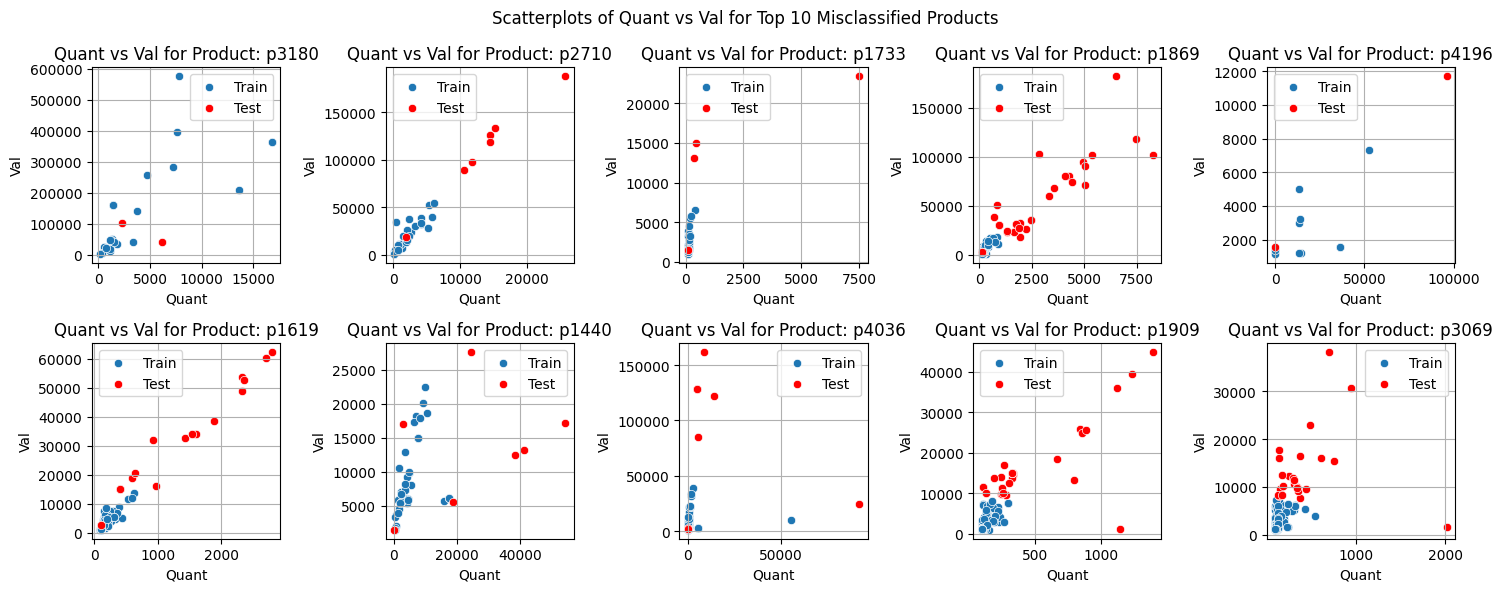

In [41]:
top_10_misclassified_prods = ranked_misclassified_percentage.head(10).index
top_10_train_data = train[train['Prod'].isin(labelencoder.inverse_transform(top_10_misclassified_prods))]
top_10_test_data = X_test[X_test['Prod'].isin(labelencoder.inverse_transform(top_10_misclassified_prods))]

n_prods = len(top_10_misclassified_prods)
n_cols = 5
n_rows = (n_prods + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for i, prod in enumerate(top_10_misclassified_prods):
    prod_name = labelencoder.inverse_transform([prod])[0]
    sns.scatterplot(x='Quant', y='Val', data=top_10_train_data[top_10_train_data['Prod'] == prod_name], label='Train', ax=axes[i])
    sns.scatterplot(x='Quant', y='Val', data=top_10_test_data[top_10_test_data['Prod'] == prod_name], color='red', label='Test', ax=axes[i])
    axes[i].set_title(f'Quant vs Val for Product: {prod_name}')
    axes[i].set_xlabel('Quant')
    axes[i].set_ylabel('Val')
    axes[i].grid(True)
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Scatterplots of Quant vs Val for Top 10 Misclassified Products')
plt.tight_layout()
plt.show()

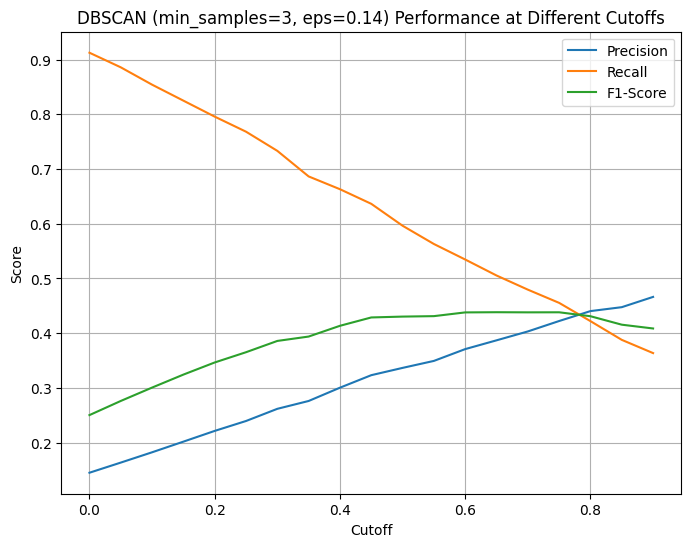

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(results['cutoff'], results['precision'], label='Precision')
plt.plot(results['cutoff'], results['recall'], label='Recall')
plt.plot(results['cutoff'], results['f1_score'], label='F1-Score')
plt.xlabel('Cutoff')
plt.ylabel('Score')
plt.title('DBSCAN (min_samples=3, eps=0.14) Performance at Different Cutoffs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# try another set of parameter for dbscan
new_dbscan = DBSCAN(eps=0.16, min_samples=5, algorithm='auto', n_jobs=-1).fit(train_log_scaled)

In [ ]:
len(np.unique(new_dbscan.labels_))

1419

In [ ]:
sum(new_dbscan.labels_==-1)

np.int64(6826)

In [ ]:
new_dbscan.core_sample_indices_.shape

(119404,)

In [ ]:
new_dbscan_predicted_scores = dbscan_predict(new_dbscan, X_test_scaled.to_numpy(), train_log_scaled.to_numpy())

In [ ]:
cutoffs = np.arange(0.0, 0.95, 0.05).round(2)
results = evaluate_model_at_cutoffs(y_test, new_dbscan_predicted_scores, cutoffs)
results

,cutoff,precision,recall,f1_score,average precision,roc_auc
0,0.00,0.147327,0.914929,0.253788,0.349827,0.850254
1,0.05,0.163355,0.898249,0.276437,0.349827,0.850254
2,0.10,0.180754,0.875730,0.299658,0.349827,0.850254
3,0.15,0.199608,0.849041,0.323226,0.349827,0.850254
4,0.20,0.217000,0.824020,0.343533,0.349827,0.850254
5,0.25,0.232586,0.796497,0.360038,0.349827,0.850254
6,0.30,0.248909,0.761468,0.375180,0.349827,0.850254
7,0.35,0.262538,0.724771,0.385451,0.349827,0.850254
8,0.40,0.279555,0.692244,0.398273,0.349827,0.850254
9,0.45,0.295896,0.661384,0.408868,0.349827,0.850254


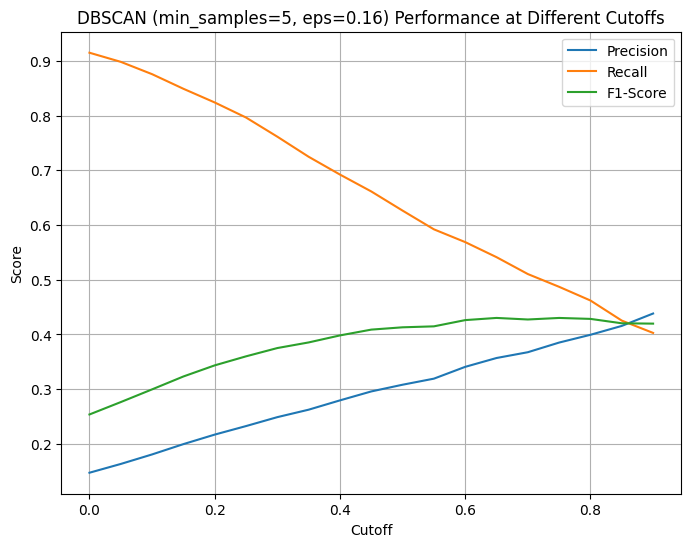

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(results['cutoff'], results['precision'], label='Precision')
plt.plot(results['cutoff'], results['recall'], label='Recall')
plt.plot(results['cutoff'], results['f1_score'], label='F1-Score')
plt.xlabel('Cutoff')
plt.ylabel('Score')
plt.title('DBSCAN (min_samples=5, eps=0.16) Performance at Different Cutoffs')
plt.legend()
plt.grid(True)
plt.show()

Use scaler trained on both training and test sets to scale the data, then train DBSCAN with the training set.

In [ ]:
X_test_scaled_combo = X_test_copy.copy()
train_log_scaled_combo = train_log.copy()

for prod in train_log_scaled_combo['Prod'].unique():
    train_prod_df = train_log_scaled_combo[train_log_scaled_combo['Prod'] == prod].copy()
    test_prod_df = X_test_scaled_combo[X_test_scaled_combo['Prod'] == prod].copy()
    prod_data = pd.concat([train_prod_df, test_prod_df])

    if not prod_data.empty:
        scaler = MinMaxScaler().fit(prod_data[numeric_col_list])
        train_log_scaled_combo.loc[train_prod_df.index, numeric_col_list] = scaler.transform(train_prod_df[numeric_col_list])
        X_test_scaled_combo.loc[test_prod_df.index, numeric_col_list] = scaler.transform(test_prod_df[numeric_col_list])

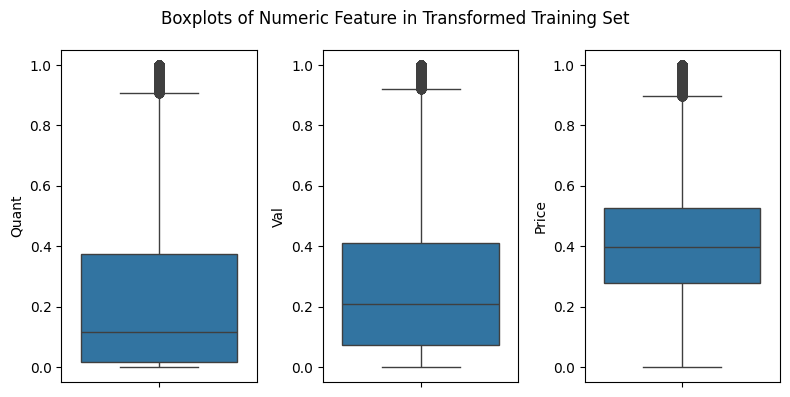

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
for i,col in enumerate(numeric_col_list):
  sns.boxplot(y=col, data=train_log_scaled_combo, ax=axes[i])
fig.suptitle('Boxplots of Numeric Feature in Transformed Training Set')
plt.tight_layout()
plt.show()

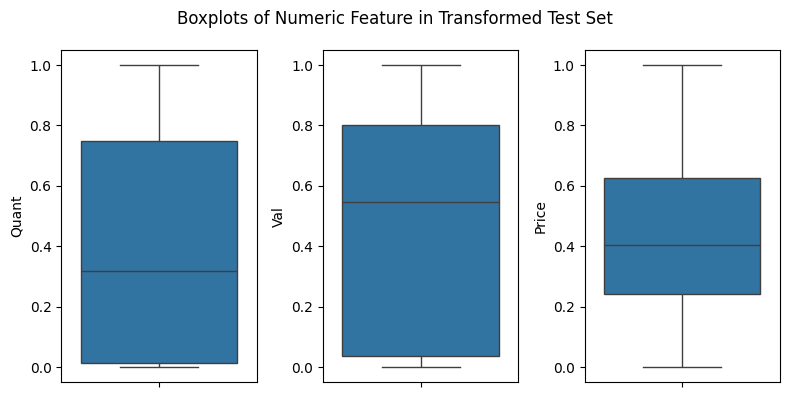

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
for i,col in enumerate(numeric_col_list):
  sns.boxplot(y=col, data=X_test_scaled_combo, ax=axes[i])
fig.suptitle('Boxplots of Numeric Feature in Transformed Test Set')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train_log_scaled_combo['Prod'] = labelencoder.fit_transform(train_log_scaled_combo['Prod'])
X_test_scaled_combo['Prod'] = labelencoder.transform(X_test_scaled_combo['Prod'])

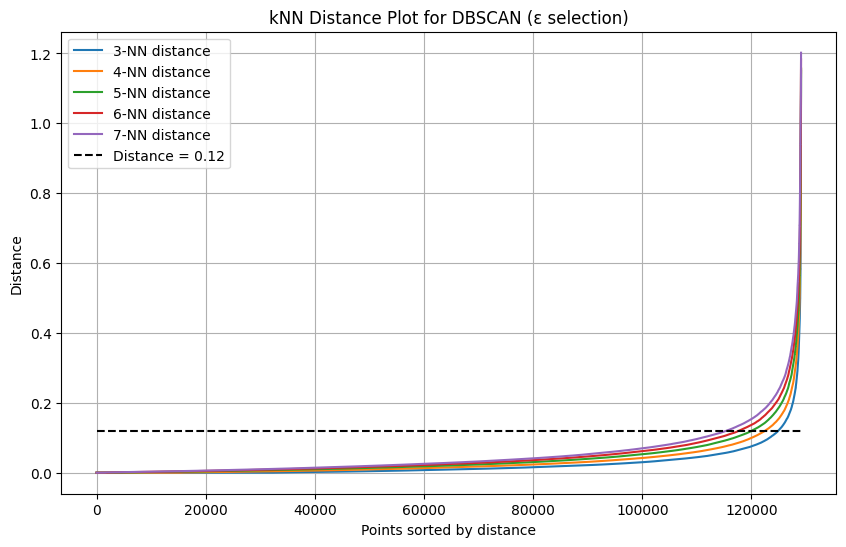

In [ ]:
from sklearn.neighbors import NearestNeighbors

plt.figure(figsize=(10, 6))
for min_samples in range(3,8):
  nbrs = NearestNeighbors(n_neighbors=min_samples).fit(train_log_scaled_combo)
  distances, _ = nbrs.kneighbors(train_log_scaled_combo)
  distances = np.sort(distances[:, min_samples-1])

  plt.plot(distances, label=f'{min_samples}-NN distance')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance')
plt.title('kNN Distance Plot for DBSCAN (ε selection)')
plt.hlines(y=0.12, xmin=0, xmax=len(train_log_scaled_combo), linestyles='dashed', colors='black', label='Distance = 0.12')
plt.legend()
plt.grid(True)

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.12, min_samples=3, algorithm='auto', n_jobs=-1).fit(train_log_scaled_combo)

In [ ]:
dbscan_combo_predicted_scores = dbscan_predict(dbscan, X_test_scaled_combo.to_numpy(), train_log_scaled_combo.to_numpy())

In [ ]:
cutoffs = np.arange(0.0, 0.95, 0.05).round(2)
results = evaluate_model_at_cutoffs(y_test, dbscan_combo_predicted_scores, cutoffs)
results

,cutoff,precision,recall,f1_score,average precision,roc_auc
0,0.00,0.162752,0.889908,0.275177,0.501892,0.863445
1,0.05,0.199178,0.849041,0.322662,0.501892,0.863445
2,0.10,0.235824,0.808173,0.365109,0.501892,0.863445
3,0.15,0.278508,0.759800,0.407606,0.501892,0.863445
4,0.20,0.324924,0.708924,0.445609,0.501892,0.863445
5,0.25,0.374286,0.655546,0.476508,0.501892,0.863445
6,0.30,0.427472,0.602168,0.500000,0.501892,0.863445
7,0.35,0.479599,0.558799,0.516179,0.501892,0.863445
8,0.40,0.539427,0.502085,0.520086,0.501892,0.863445
9,0.45,0.585714,0.444537,0.505453,0.501892,0.863445


combine with LocalOutlierFactor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

X_train = train_log_scaled.to_numpy()
X_test = X_test_scaled.to_numpy()
dbscan_lof_predicted_score = np.zeros(shape=len(X_test), dtype=float)
core_samples_indices = new_dbscan.core_sample_indices_
core_samples = X_train[core_samples_indices]
dbscan_outliers = X_train[new_dbscan.labels_ == -1]
eps = new_dbscan.eps

lof = LocalOutlierFactor(n_neighbors=10, novelty=True).fit(dbscan_outliers)
train_lof_scores = -lof.negative_outlier_factor_
scaler_lof_scores = MinMaxScaler().fit(train_lof_scores.reshape(-1, 1))

for j, x_new in enumerate(X_test):
    x_new_array = np.array([x_new])
    distances_to_core = euclidean_distances(x_new_array, core_samples)[0]
    min_dist = np.min(distances_to_core)

    if min_dist <= eps:
        probability = 0.0
    else:
        lof_score = -lof.score_samples(x_new_array.reshape(1,-1))
        probability = scaler_lof_scores.transform(lof_score.reshape(1, -1))[0][0]
        probability = max(0.0, min(1.0, probability))

        dbscan_lof_predicted_score[j] = probability

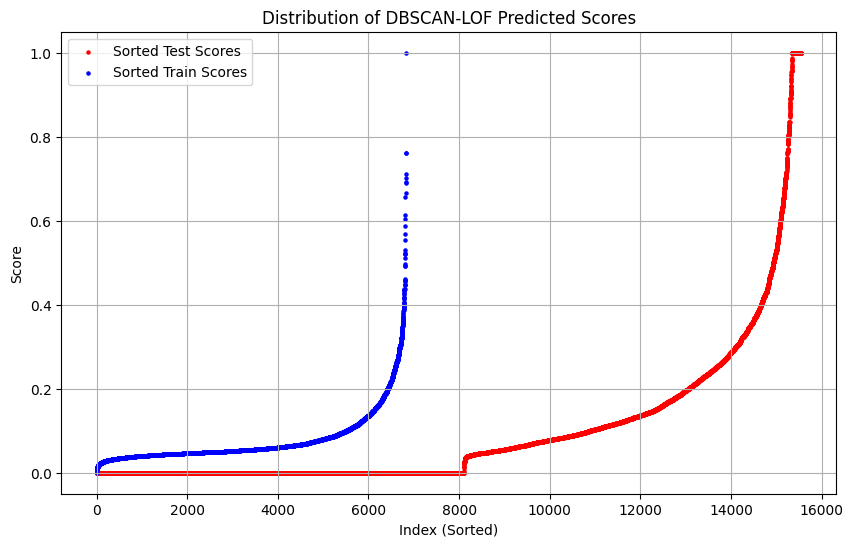

In [ ]:
sorted_test_scores = np.sort(dbscan_lof_predicted_score)
sorted_train_scores = np.sort(scaler_lof_scores.transform(train_lof_scores.reshape(-1, 1)).flatten())

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(sorted_test_scores)), sorted_test_scores, color='red', s=5, label='Sorted Test Scores')
plt.scatter(np.arange(len(sorted_train_scores)), sorted_train_scores, color='blue', s=5, label='Sorted Train Scores')
plt.title('Distribution of DBSCAN-LOF Predicted Scores')
plt.xlabel('Index (Sorted)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

In [ ]:
cutoffs = np.arange(0.0, 0.95, 0.05).round(2)
results = evaluate_model_at_cutoffs(y_test, dbscan_lof_predicted_score, cutoffs)
results

,cutoff,precision,recall,f1_score,average precision,roc_auc
0,0.00,0.147327,0.914929,0.253788,0.272085,0.788468
1,0.05,0.151701,0.866555,0.258201,0.272085,0.788468
2,0.10,0.172154,0.667223,0.273691,0.272085,0.788468
3,0.15,0.201686,0.538782,0.293503,0.272085,0.788468
4,0.20,0.214142,0.444537,0.289046,0.272085,0.788468
5,0.25,0.240977,0.378649,0.294518,0.272085,0.788468
6,0.30,0.278437,0.332777,0.303191,0.272085,0.788468
7,0.35,0.310654,0.289408,0.299655,0.272085,0.788468
8,0.40,0.342404,0.251877,0.290245,0.272085,0.788468
9,0.45,0.379358,0.226856,0.283925,0.272085,0.788468


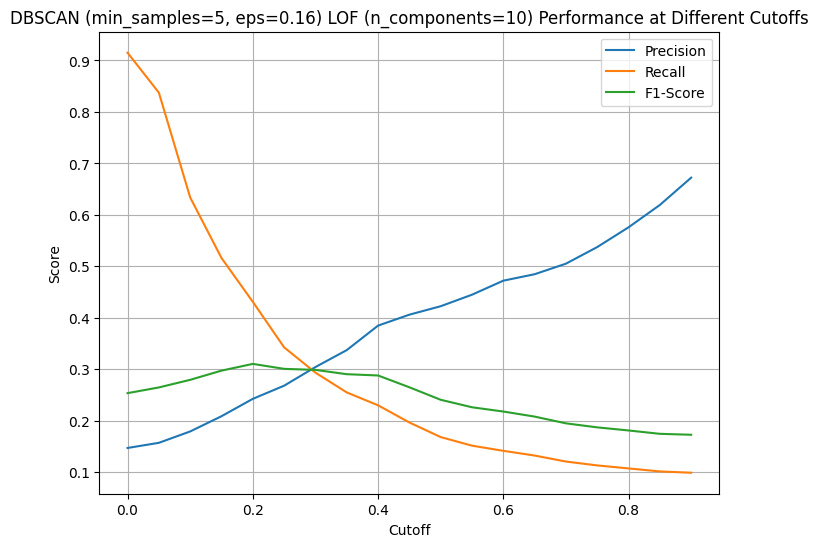

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(results['cutoff'], results['precision'], label='Precision')
plt.plot(results['cutoff'], results['recall'], label='Recall')
plt.plot(results['cutoff'], results['f1_score'], label='F1-Score')
plt.xlabel('Cutoff')
plt.ylabel('Score')
plt.title('DBSCAN (min_samples=5, eps=0.16) LOF (n_components=10) Performance at Different Cutoffs')
plt.legend()
plt.grid(True)
plt.show()

Analyze by product

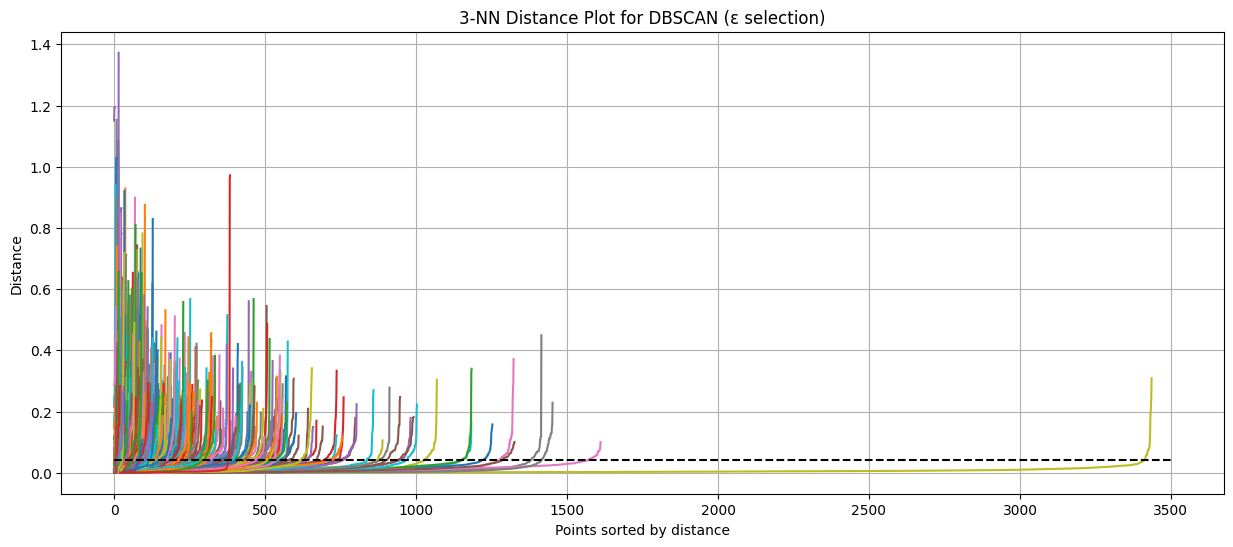

In [ ]:
from sklearn.neighbors import NearestNeighbors

plt.figure(figsize=(15, 6))
for prod in train_log_scaled['Prod'].unique():
  train_prod_df = train_log_scaled[train_log_scaled['Prod'] == prod].copy()
  nbrs = NearestNeighbors(n_neighbors=3).fit(train_prod_df[numeric_col])
  distances, _ = nbrs.kneighbors(train_prod_df[numeric_col])
  distances = np.sort(distances[:, 2])

  plt.plot(distances, label=f'{prod}')

plt.xlabel('Points sorted by distance')
plt.ylabel('Distance')
plt.hlines(y=0.04, xmin=0, xmax=3500, linestyles='dashed', colors='black')
plt.title('3-NN Distance Plot for DBSCAN (ε selection)')
plt.grid(True)

In [ ]:
def eps_estimation(array):
  nbrs = NearestNeighbors(n_neighbors=3).fit(array)
  distances, _ = nbrs.kneighbors(array)
  distances = np.sort(distances[:, 2])

  if len(distances) < 5:
      return 0.2

  x = np.arange(len(distances))
  y = distances

  dy = np.gradient(y, x)
  ddy = np.gradient(dy, x)
  curvature = np.abs(ddy) / (1 + dy**2)**1.5

  elbow_index = np.argmax(curvature)
  eps_est = distances[elbow_index]

  # Add a check for a reasonable minimum eps value, as calculated eps can be very small
  if eps_est < 0.005:
      eps_est = 0.005

  return eps_est, elbow_index
  # this approach didn't work so well unfortunately

In [ ]:
test_dbscan_scores = pd.Series(index=X_test_scaled.index, dtype=float)

for prod in train_log_scaled['Prod'].unique():
    train_prod_df_scaled = train_log_scaled[train_log_scaled['Prod'] == prod].copy()
    test_prod_df_scaled = X_test_scaled[X_test_scaled['Prod'] == prod].copy()

    if not train_prod_df.empty and not test_prod_df.empty:
        train_prod_scaled_numeric = train_prod_df_scaled[numeric_col].to_numpy()
        test_prod_scaled_numeric = test_prod_df_scaled[numeric_col].to_numpy()
        # eps_est = eps_estimation(train_prod_scaled_numeric) this estimate is not all accurate
        dbscan_prod = DBSCAN(eps=0.04, min_samples=3, n_jobs=-1)
        dbscan_prod.fit(train_prod_scaled_numeric)

        prod_scores = dbscan_predict(dbscan_prod, test_prod_scaled_numeric, train_prod_scaled_numeric)

        test_dbscan_scores[test_prod_df_scaled.index] = prod_scores

In [ ]:
cutoffs = np.arange(0.0, 0.55, 0.05).round(2)
results = evaluate_model_at_cutoffs(y_test, test_dbscan_scores, cutoffs)
results

,cutoff,precision,recall,f1_score,average precision,roc_auc
0,0.00,0.112117,0.960801,0.200802,0.20335,0.792749
1,0.05,0.127650,0.929108,0.224461,0.20335,0.792749
2,0.10,0.142743,0.894078,0.246182,0.20335,0.792749
3,0.15,0.158158,0.844871,0.266439,0.20335,0.792749
4,0.20,0.171679,0.785655,0.281783,0.20335,0.792749
5,0.25,0.185265,0.721435,0.294819,0.20335,0.792749
6,0.30,0.193091,0.648040,0.297530,0.20335,0.792749
7,0.35,0.205113,0.588824,0.304245,0.20335,0.792749
8,0.40,0.214624,0.528774,0.305321,0.20335,0.792749
9,0.45,0.216248,0.459550,0.294102,0.20335,0.792749


### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
IF = IsolationForest(n_estimators=100, contamination=0.08).fit(train_log_scaled)
IF_pred = IF.predict(X_test_scaled)
IF_pred[IF_pred==1] = 0
IF_pred[IF_pred==-1] = 1

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score
auc = roc_auc_score(y_test, IF_pred)
precision = average_precision_score(y_test, IF_pred)
recall = recall_score(y_test, IF_pred)
f1 = f1_score(y_test, IF_pred)
print(f'AUC: {auc}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

AUC: 0.6237857190650442, Precision: 0.10142374338922816, Recall: 0.8315262718932444, F1-Score: 0.18857575184414602


In [ ]:
IF_pred = pd.Series(index=X_test_scaled.index, dtype=float)

for prod in train_log_scaled['Prod'].unique():
    train_prod_df = train_log_scaled[train_log_scaled['Prod'] == prod][numeric_col_list]
    test_prod_df = X_test_scaled[X_test_scaled['Prod'] == prod][numeric_col_list]
    IF = IsolationForest(n_estimators=100, contamination=0.08).fit(train_prod_df)
    pred = IF.predict(test_prod_df)
    pred[pred==1] = 0
    pred[pred==-1] = 1
    IF_pred[test_prod_df.index] = pred

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score
auc = roc_auc_score(y_test, IF_pred)
precision = average_precision_score(y_test, IF_pred)
recall = recall_score(y_test, IF_pred)
f1 = f1_score(y_test, IF_pred)
print(f'AUC: {auc}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

AUC: 0.6266330245581734, Precision: 0.10184629501083745, Recall: 0.8632193494578816, F1-Score: 0.18843878015475649


In [ ]:
IF_pred = pd.Series(index=X_test_scaled.index, dtype=float)

for prod in train_log_scaled['Prod'].unique():
    train_prod_df = train_log_scaled[train_log_scaled['Prod'] == prod][numeric_col_list]
    test_prod_df = X_test_scaled[X_test_scaled['Prod'] == prod][numeric_col_list]
    combined_prod_df = pd.concat([train_prod_df, test_prod_df])
    IF = IsolationForest(n_estimators=100, contamination=0.1).fit(combined_prod_df)
    pred = IF.predict(test_prod_df)
    pred[pred==1] = 0
    pred[pred==-1] = 1
    IF_pred[test_prod_df.index] = pred

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score
auc = roc_auc_score(y_test, IF_pred)
precision = average_precision_score(y_test, IF_pred)
recall = recall_score(y_test, IF_pred)
f1 = f1_score(y_test, IF_pred)
print(f'AUC: {auc}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

AUC: 0.7779508643532258, Precision: 0.16730684685075753, Recall: 0.914095079232694, F1-Score: 0.2948614474038203
